In [2]:
%matplotlib ipympl

__requires__ = "numpy==1.24"

import pkg_resources
pkg_resources.require(__requires__)

import multiprocessing as mp
import numpy as np
print(np. __version__)
import pandas as pd
from numba import njit, jit
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sb
import time
import pprint

from IPython.display import display
from ipywidgets import interactive
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

sb.set()
pp = pprint.PrettyPrinter(indent=4)

DELAY = 0.2
FRACTION = 0.2
SNR = 3  # Signal to noise ratio

SLICE_START = 0
SLICE_END = 10000
DELAY_SAMPLES = 100
INV_FRAC = 3.7

# CUR_DIR = os.getcwd()

SN1 = "../data/SN1_Chirp_300kHzTemplate_0p16SNR_280Start_Sig.npy"  # Nasty noise
SN2 = "../data/SN2_Chirp_300kHzTemplate_0p32SNR_280Start_Sig.npy"  # Nice noise
SX1 = "../data/SX1_ChirpSig_ChirpTemplate_325p5kHz_3p45e8Grad_1024pt_99mV.npy"
SX2 = "../data/SX2_ChirpSig_ChirpTemplate_325p5kHz_3p45e8Grad_1024pt_132mV.npy"
SX3 = "../data/SX3_ChirpSig_ChirpTemplate_325p5kHz_3p45e8Grad_1024pt_264mV.npy"
XN1 = "../data/XN1_Chirp_300kHzTemplate_0p16SNR_280Start_Noise.npy"
XN2 = "../data/XN2_Chirp_300kHzTemplate_0p32SNR_280Start_Noise.npy"

data = {}
# data["SN1"] = np.array(list( zip(*np.load(SN1)) ))
# data["SN2"] = np.array(list( zip(*np.load(SN2)) ))
data["SX1"] = np.array(list( zip(*np.load(SX1)) ))
# data["SX2"] = np.array(list( zip(*np.load(SX2)) ))
# data["SX3"] = np.array(list( zip(*np.load(SX3)) ))
data["XN1"] = np.array(list( zip(*np.load(XN1)) ))
# data["XN2"] = np.array(list( zip(*np.load(XN2)) ))


1.24.0


In [3]:
# Simulated functions written as generators to closer replicate the description in Verilog

def LP_filt(x_all, DECAY_FULL_POWER=10, DECAY_PART=900):
    """ Low-pass IIR filter simulation of Verilog implementation
    Write as a generator to simulate verilog functionality
    Default DECAY_FULL_POWER = 10 so that DECAY_FULL = 1024
    """
    a = ( 2 ** DECAY_FULL_POWER ) - DECAY_PART
    b = DECAY_PART
    
    last_y = 0
    
    for x in x_all:  # always @ (posedge clk)
        y = ( a * x ) + ( b * last_y )
        y = y >> DECAY_FULL_POWER  # Arithmetic shift to divide by DECAY_FULL
        last_y = y
        yield y

def CFD(x_all, inv_frac=3, delay_samples = 100):
    """Simulation of the constant fraction discriminator (CFD) described in Verilog.
    As normally described, the parameters are `fraction` and `delay`.
    The parameter `inv_frac` is `1/fraction`, so can multiply the conjugate variable rather than divide (which is easier to synthesise).
    The parameter `delay_samples` is `delay * sample_rate`.
    """
    buffer = np.zeros(delay_samples)  # In effect delays the input

    for x in x_all:  # Simulate `always @ (posedge clk)`
        # Buffer update and shift
        for i in range( delay_samples - 2, 0 - 1, -1 ):
            buffer[i+1] = buffer[i]
        buffer[0] = x
        
        # CFD calculation
        working = buffer[delay_samples-1]  # Delay
        working = - working * inv_frac  # Negate and augment (equivalent to attenuating x)
        y = x + working
        yield y

def zero_detector(x_all):
    sign = 0
    for x in x_all:  # Simulate `always @ (posedge clk)`
        # Two's complement: MSB is 0 for non-negatives (including 0), and 1 for negatives
        last_sign = sign;
        sign = 0 if x >= 0 else 1
        y = sign ^ last_sign  # In Verilog would be a continuous assignment `assign y = sign ^ last_sign` declared at the beginning
        yield y

def zero_detector2(x_all):
    """A variation of `zero_detector()` that only detects rising edges of zero crossings.
    NB: using two's complement, so MSB is 0 for non-negatives (including 0), and 1 for negatives
    """
    sign = 0
    for x in x_all:  # Simulate `always @ (posedge clk)`
        last_sign = sign;
        sign = 0 if x >= 0 else 1  # In Verilog would be a continuous assignment `assign y = ???` declared at the beginning
        y = sign & ~last_sign  # NB using two's complement, so need -ve & +ve i.e. 1 & 0
        yield y

#=========================

@njit
def LP_filt_njit(x_all, DECAY_FULL_POWER=10, DECAY_PART=900):
    """ Low-pass IIR filter simulation of Verilog implementation
    Write as a generator to simulate verilog functionality
    Default DECAY_FULL_POWER = 10 so that DECAY_FULL = 1024
    """
    a = ( 2 ** DECAY_FULL_POWER ) - DECAY_PART
    b = DECAY_PART
    
    last_y = 0
    
    for x in x_all:  # always @ (posedge clk)
        y = ( a * x ) + ( b * last_y )
        y = y >> DECAY_FULL_POWER  # Arithmetic shift to divide by DECAY_FULL
        last_y = y
        yield y

@njit
def CFD_njit(x_all, inv_frac=3, delay_samples = 100):
    """Simulation of the constant fraction discriminator (CFD) described in Verilog.
    As normally described, the parameters are `fraction` and `delay`.
    The parameter `inv_frac` is `1/fraction`, so can multiply the conjugate variable rather than divide (which is easier to synthesise).
    The parameter `delay_samples` is `delay * sample_rate`.
    """
    buffer = np.zeros(delay_samples)  # In effect delays the input

    for x in x_all:  # Simulate `always @ (posedge clk)`
        # Buffer update and shift
        for i in range( delay_samples - 2, 0 - 1, -1 ):
            buffer[i+1] = buffer[i]
        buffer[0] = x
        
        # CFD calculation
        working = buffer[delay_samples-1]  # Delay
        working = - working * inv_frac  # Negate and augment (equivalent to attenuating x)
        y = x + working
        yield y

@njit
def zero_detector2_njit(x_all):
    """A variation of `zero_detector()` that only detects rising edges of zero crossings.
    NB: using two's complement, so MSB is 0 for non-negatives (including 0), and 1 for negatives
    """
    sign = 0
    for x in x_all:  # Simulate `always @ (posedge clk)`
        last_sign = sign;
        sign = 0 if x >= 0 else 1  # In Verilog would be a continuous assignment `assign y = ???` declared at the beginning
        y = sign & ~last_sign  # NB using two's complement, so need -ve & +ve i.e. 1 & 0
        yield y



In [5]:
class SignalData(object):
    def __init__(self,
                 data,
                 truth_data = None,
                 
                 filter_alg = LP_filt,
                 cfd_alg = CFD,
                 zero_detector_alg = zero_detector,
                 
                 slice_start = 0,
                 slice_end = None,  # None sends the slice to the end
                 delay_samples = DELAY_SAMPLES,
                 inv_frac = INV_FRAC,
                 amp_power = 16,
                ):
        self.all_t = data[0]
        self.all_sig = data[1]

        self.filter = filter_alg
        self.cfd = cfd_alg
        self.zd = zero_detector_alg

        if truth_data is not None:
            if len(data[0]) != len(truth_data):
                # raise IndexError(f"data[0] and truth_data length mismatch: { len(data[0]) } and { len(truth_data) }")
                print("NOPE")
                return None
            self.all_truth_data = truth_data
        else:
            self.all_truth_data = np.zeros_like(self.all_t)
        
        if slice_end is None:
            slice_end = len(data[0])
        self.slice_end = slice_end

        self.all_computed_performances = []

        self.slice_start = slice_start
        self.slice_end = slice_end
        self.delay_samples = delay_samples
        self.inv_frac = inv_frac
        self.amp_power = amp_power

        self.regenerate()

    def __len__(self):
        # return len(self.t)
        return self.slice_end - self.slice_start

    def regenerate(self):
        self.slice()
        self.run_amp()
        self.run_fil()
        self.run_cfd()
        self.run_zd()

    def slice(self):
        self.t = self.all_t[self.slice_start:self.slice_end]
        self.sig = self.all_sig[self.slice_start:self.slice_end]
        self.truth_data = self.all_truth_data[self.slice_start:self.slice_end]

    def run_amp(self):
        self.sig_amp = [ int(i * 2 ** 16 ) for i in self.sig ]

    def run_fil(self):
        filtered = self.filter(self.sig_amp)
        self.sig_fil = np.array(list(filtered))
        return self.sig_fil

    def run_cfd(self):
        cfd_done = self.cfd(self.sig_fil, delay_samples=self.delay_samples, inv_frac=self.inv_frac)
        self.sig_cfd = np.array(list(cfd_done))
        return self.sig_cfd

    def run_zd(self):
        zd_done = self.zd(self.sig_cfd)
        self.output = np.array(list(zd_done))
        return self.output
    

    def get_zero_data(self):
        bar_t = []
        bar_z = []
        for index, item in enumerate(self.output):
            if item != 0:
                bar_t.append(self.t[index])
                bar_z.append(item)
        return bar_t, bar_z

    def set_truth_data(self, truth_data):
        self.truth_data = truth_data
        self.slice()


    def get_inv_frac_performance(self, tolerance, output_to_analyse=None, verbose=False):
        """
        If output_to_analyse is None, use self.output. This is so that get_performance_parallel() can
        run without changing instance variables and affecting other processes.
        --- make this a class method?
        """
        if output_to_analyse is None:
            output_to_analyse = self.output
        
        test_parameters = {}
                
        spacing = self.all_t[1] - self.all_t[0]  # Assumes constant sample time-spacing
        tolerance_samples = int(tolerance / spacing)

        total_signals = np.sum(self.truth_data)
        total_triggers = np.sum(output_to_analyse)
        
        hits = 0
        for idx, val in enumerate(self.truth_data):
            if not val:
                continue
            lower = max(self.slice_start, idx - tolerance_samples)
            upper = min(idx + tolerance_samples, self.slice_end)
            for search_idx in range(lower, upper):
                if output_to_analyse[search_idx]:
                    hits += 1
                    break
            else:
                continue
        hitrate = hits / total_signals

        misfires = 0
        for idx, val in enumerate(output_to_analyse):
            if not val:
                continue
            lower = max(self.slice_start, idx - tolerance_samples)
            upper = min(idx + tolerance_samples, self.slice_end)
            for search_idx in range(lower, upper):
                if self.truth_data[search_idx]:
                    break
            else:
                misfires += 1
        misfire_rate = misfires / total_triggers

        performance = ( hitrate + (1 - misfire_rate) ) / 2

        if verbose:
            print("self.delay_samples:", self.delay_samples)
            print("self.inv_frac:", self.inv_frac)
            print("tolerance:", tolerance)
            print("tolerance_samples:", tolerance_samples)
            print("total_signals:", total_signals)
            print("total_triggers:", total_triggers)
            print("hits:", hits)
            print("misfires:", misfires)
            print("misfire_rate:", misfire_rate)  # Possible misleading statistic
            print("performance:", performance)  # Possible misleading statistic
            print()

        # Record test parameters and outputs
        test_parameters["delay_samples"] = self.delay_samples
        test_parameters["inv_frac"] = self.inv_frac
        test_parameters["tolerance"] = tolerance
        test_parameters["tolerance_samples"] = tolerance_samples
        test_parameters["total_signals"] = total_signals
        test_parameters["total_triggers"] = total_triggers
        test_parameters["hits"] = hits
        test_parameters["hitrate"] = hitrate
        test_parameters["misfires"] = misfires
        test_parameters["misfire_rate"] = misfire_rate
        test_parameters["performance"] = performance

        return test_parameters

    # @njit
    def get_performance(self, inv_frac_vals, delay_samples_vals, tolerance=100e-6, verbose=False):
        all_performances = []
        for delay_samples in delay_samples_vals:
            self.delay_samples = delay_samples
            if verbose: print("." * len(inv_frac_vals) + f" {delay_samples}")
            for inv_frac in inv_frac_vals:
                self.inv_frac = inv_frac
                # Only run CFD and ZD, where self.regenerate() would also fun the amplifier and filter
                self.run_cfd()
                self.run_zd()
                all_performances.append( self.get_inv_frac_performance(tolerance=tolerance) )
                if verbose: print(".", end="")
            if verbose: print()
        if verbose: print("computation completed")
        return all_performances
    
    @jit
    def get_performance_jit(self, inv_frac_vals, delay_samples_vals, tolerance=100e-6, verbose=False):
        all_performances = []
        for delay_samples in delay_samples_vals:
            self.delay_samples = delay_samples
            if verbose: print("." * len(inv_frac_vals) + f" {delay_samples}")
            for inv_frac in inv_frac_vals:
                self.inv_frac = inv_frac
                # Only run CFD and ZD, where self.regenerate() would also fun the amplifier and filter
                self.run_cfd()
                self.run_zd()
                all_performances.append( self.get_inv_frac_performance(tolerance=tolerance) )
                if verbose: print(".", end="")
            if verbose: print()
        if verbose: print("computation completed")
        return all_performances

    def foobuh(self, delay_samples, inv_frac, tolerance):
        cfd_done = self.cfd(self.sig_fil, delay_samples=delay_samples, inv_frac=inv_frac)
        sig_cfd = np.array(list(cfd_done))
        zd_done = self.zd(sig_cfd)
        output = np.array(list(zd_done))
        print(".")
        return self.get_inv_frac_performance(tolerance=tolerance, output_to_analyse=output)

    def get_performance_parallel(self, inv_frac_vals, delay_samples_vals, tolerance=100e-6, verbose=False):
        collect_result = lambda results: self.all_computed_performances.append( results )

        np = mp.cpu_count()
        with Pool(processes=np) as pool:

            for delay_samples in delay_samples_vals:
                if verbose: print("." * len(inv_frac_vals) + f" {delay_samples}")
                for inv_frac in inv_frac_vals:
                    POOL.apply_async(self.foobuh,
                                     args = (self, delay_samples, inv_frac, tolerance),
                                     callback = collect_result,
                                    )
                    # if verbose: print(".", end="")
                # if verbose: print()
        # POOL.close()
        # if verbose: print("awaiting syncs")
        # POOL.join()
        if verbose: print("computation completed")
        return self.all_computed_performances



C:\Users\roysi\AppData\Local\Temp\ipykernel_5512\1623808162.py:186: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


In [5]:
class InteractiveTrigger(SignalData):
    def __init__(self,
                 data, 
                 slice_start=SLICE_START,
                 slice_end=SLICE_END,
                 delay_samples=DELAY_SAMPLES,
                 inv_frac=INV_FRAC,
                 *args,
                 **kwargs,
                ):
        super().__init__(
            data=data, 
            slice_start=SLICE_START,
            slice_end=SLICE_END,
            delay_samples=DELAY_SAMPLES,
            inv_frac=INV_FRAC,
            *args,
             **kwargs,
        )
        self.fig, self.axis = plt.subplots(figsize=(10, 6))
        
        self.axis.plot(self.t, self.sig_amp, label="Amplifier output")
        self.axis.plot(self.t, self.sig_fil, label="Filter output")
        self.plt_cfd, = self.axis.plot(self.t, self.sig_cfd, label="CFD output")
        self.plt_zer = self.axis.scatter(*self.get_zero_data(), label="ZD output", marker="x", color="purple", s=1000, zorder=3)
        
    def update(self, delay_samples=None, inv_frac=None):
        if delay_samples is not None: self.delay_samples = delay_samples
        if inv_frac is not None: self.inv_frac = inv_frac
        
        self.run_cfd()
        self.run_zd()
        
        self.plt_cfd.set_ydata(self.sig_cfd)
        self.plt_zer.remove()        
        self.plt_zer = self.axis.scatter(*self.get_zero_data(), label="ZD output", marker="x", color="purple", s=1000, zorder=3)
        plt.legend(loc = "upper right")
        plt.show()


In [6]:
image1 = InteractiveTrigger(
        data["SX1"],
        slice_start=0,
        slice_end=3000,
        zero_detector_alg=zero_detector2,
    )

interact(image1.update,
      delay_samples=widgets.IntSlider(min=0, max=300, step=1, value=DELAY_SAMPLES), 
      inv_frac=widgets.FloatSlider(min=0, max=6, step=0.1, value=INV_FRAC)
    )


interactive(children=(IntSlider(value=100, description='delay_samples', max=300), FloatSlider(value=3.7, descr…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

sample_spacing 1e-06
pulse_spacing 0.002 (2ms)

samples_per_chirp: 2000
samples: 1006484
chirp_no: 503.242
samples_trunc: 1006000
chirp_no_trunc: 503

mean: 1594


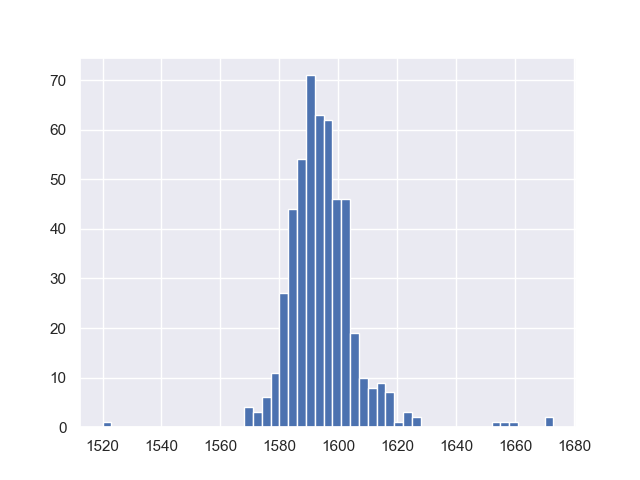

In [9]:
# Create truth data for SX1

# Find position of chirp per cycle

t = data["SX1"][0]
sig = data["SX1"][1]

sample_spacing = 1e-6
pulse_spacing = 2e-3  # 2ms
print("sample_spacing", sample_spacing)
print("pulse_spacing", pulse_spacing, "(2ms)")
print()

samples_per_chirp = int(pulse_spacing / sample_spacing)
samples = len(t)
chirp_no = samples / samples_per_chirp

print("samples_per_chirp:", samples_per_chirp)
print("samples:", samples)
print("chirp_no:", chirp_no)

samples_trunc = samples - (samples % samples_per_chirp)
chirp_no_trunc = samples_trunc // samples_per_chirp
print("samples_trunc:", samples_trunc)
print("chirp_no_trunc:", chirp_no_trunc)

t_trunc = t[:samples_trunc]
sig_trunc = sig[:samples_trunc]

chirp_sections = []
for i in range(chirp_no_trunc-1):
    section_start = samples_per_chirp * i
    section_end = samples_per_chirp * (i + 1)
    t_section = t[section_start:section_end]
    sig_section = sig[section_start:section_end]
    chirp_section = (t_section, sig_section)
    chirp_sections.append(chirp_section)

tops = []
for t_section, sig_section in chirp_sections:
    max_idx = np.argmax(sig_section)
    tops.append(max_idx)

print()
mean = int(np.mean((tops)))
print("mean:", mean)

fig, axis = plt.subplots()
axis.hist(tops, bins="auto")

# Create truth data
SX1_truth_data = np.zeros(1006484)
for i in range(chirp_no_trunc):
    idx_of_chirp = samples_per_chirp * i + mean
    SX1_truth_data[idx_of_chirp] = True


In [10]:
def plot_inv_frac(df, delay_samples=100):
    df = df[ df.delay_samples == delay_samples ]
    
    fig, (ax1_1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(12)
    fig.set_figheight(4)
    
    # Initial plot
    
    ax1_1.set_title(f"SX1 analysis, delay_samples={ delay_samples }")
    ax1_1.set_xlabel("inv_frac")
    color = "tab:green"
    ax1_1.set_ylabel("Hitrate", color=color)
    ax1_1.plot(df.inv_frac, df.hitrate, color=color)
    ax1_1.tick_params(axis='y', labelcolor=color)
    
    ax1_2 = ax1_1.twinx()  # instantiate a second axes that shares the same x-axis
    color = "tab:red"
    ax1_2.set_ylabel("Misfires", color=color)  # we already handled the x-label with ax1
    ax1_2.plot(df.inv_frac, df.misfires, color=color)
    ax1_2.tick_params(axis='y', labelcolor=color)
    
    
    # Get and plot misfire rates and performances
    
    ax2.set_title(f"SX1 analysis, delay_samples={ delay_samples }")
    ax2.set_xlabel("inv_frac")
    ax2.set_ylim([0, 1.05])
    ax2.plot(df.inv_frac, df.hitrate, label="Hitrate", color="tab:green", linestyle="dotted")
    ax2.plot(df.inv_frac, df.misfire_rate, label="Misfire Rate", color="tab:red", linestyle="dotted")
    ax2.plot(df.inv_frac, df.performance, label="Combined Performance", color="tab:blue")
    ax2.legend()

    fig.tight_layout()  # Otherwise the right y-label is slightly clipped (for axis1)
    plt.show()

def plot_all_3d(df, title="untitled"):
    fig, (ax1, ax2) = plt.subplots(1, 2, 
                                   subplot_kw={"projection": "3d"}, 
                                   # gridspec_kw = {'wspace':0.01, 'hspace':0},
                                   figsize=(12, 8))
    x = df.inv_frac
    y = df.delay_samples

    fig.suptitle(title)
    fig.tight_layout()
    
    ax1.set_title("Hitrate")
    cmap = plt.get_cmap("plasma")
    ax1.set_xlabel("inv_frac")
    ax1.set_ylabel("delay_samples")
    ax1.set_zlabel("hitrate")
    ax1.plot_trisurf(x, y, df.hitrate, cmap=cmap, linewidth=0.2)

    ax2.set_title("Misfire rate")
    cmap = plt.get_cmap("plasma_r")
    ax2.set_xlabel("inv_frac")
    ax2.set_ylabel("delay_samples")
    ax2.set_zlabel("misfire_rate")
    ax2.set_zlim([0, 1])
    ax2.plot_trisurf(x, y, df.misfire_rate, cmap=cmap, linewidth=0.2)
    plt.show()

# t2_pd_analyse = pd.read_csv("t2_performance_data 2023 08 21 - SX1 8hrs to compute")
# plot_all_3d(t2_pd_analyse, title="SX1 full range, zd2")


In [24]:
x = np.arange(100).reshape(10, 10)

@jit(nopython=True)
def go_fast(a): # Function is compiled and runs in machine code
    trace = 0.0
    for i in range(a.shape[0]):
        trace += np.tanh(a[i, i])
    return a + trace

# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
go_fast(x)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
go_fast(x)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))


Elapsed (with compilation) = 0.5309863090515137
Elapsed (after compilation) = 0.0


In [12]:
%%time

t1_all_test_params = t1.get_performance(inv_frac_vals = inv_frac_vals,
                                        delay_samples_vals = delay_samples_vals,
                                        tolerance = 100e-6,
                                        verbose = True,
                                       )
t1_pd = pd.DataFrame(t1_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
t1_pd.to_csv("t1_performance_data")


..... 50
.....
..... 100
.....
..... 150
.....
..... 200
.....
computation completed
CPU times: total: 19.4 s
Wall time: 42.1 s


In [27]:
# %%time

start = time.time()
t1_all_test_params = t1.get_performance_jit(inv_frac_vals = inv_frac_vals,
                                        delay_samples_vals = delay_samples_vals,
                                        tolerance = 100e-6,
                                        verbose = True,
                                       )
t1_pd = pd.DataFrame(t1_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
t1_pd.to_csv("t1_performance_data")
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))


start = time.time()
t1_all_test_params = t1.get_performance_jit(inv_frac_vals = inv_frac_vals,
                                        delay_samples_vals = delay_samples_vals,
                                        tolerance = 100e-6,
                                        verbose = True,
                                       )
t1_pd = pd.DataFrame(t1_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
t1_pd.to_csv("t1_performance_data")
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))


..... 50
.....
..... 100
.....
..... 150
.....
..... 200
.....
computation completed
Elapsed (with compilation) = 50.50360321998596
..... 50
.....
..... 100
.....
..... 150
.....
..... 200
.....
computation completed
Elapsed (after compilation) = 45.26994585990906


In [ ]:
# %%time

# t1_all_test_params = t1.get_performance_parallel(inv_frac_vals = inv_frac_vals,
#                                                  delay_samples_vals = delay_samples_vals,
#                                                  tolerance = 100e-6,
#                                                  verbose = True,
#                                                 )
# t1_pd = pd.DataFrame(t1_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
# t1_pd.to_csv("t1_performance_data")


..... 50
..... 100
..... 150
..... 200
awaiting syncs


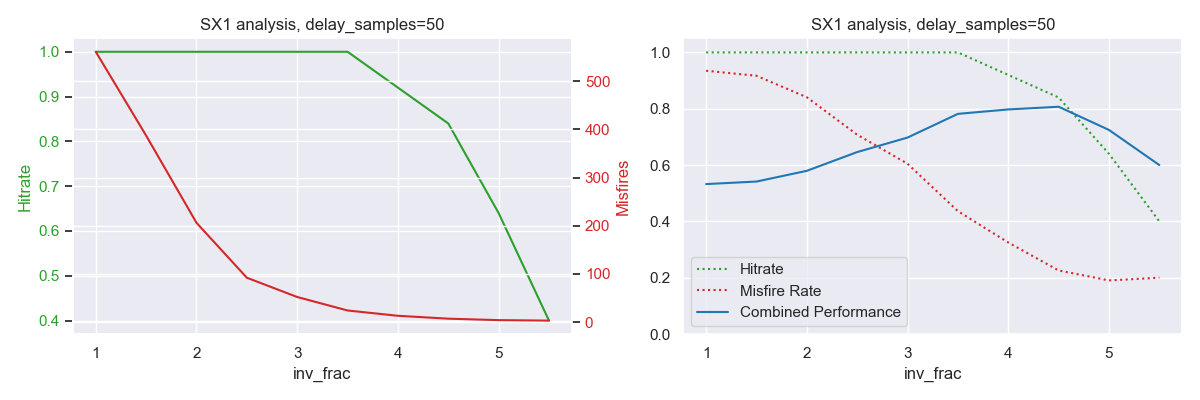

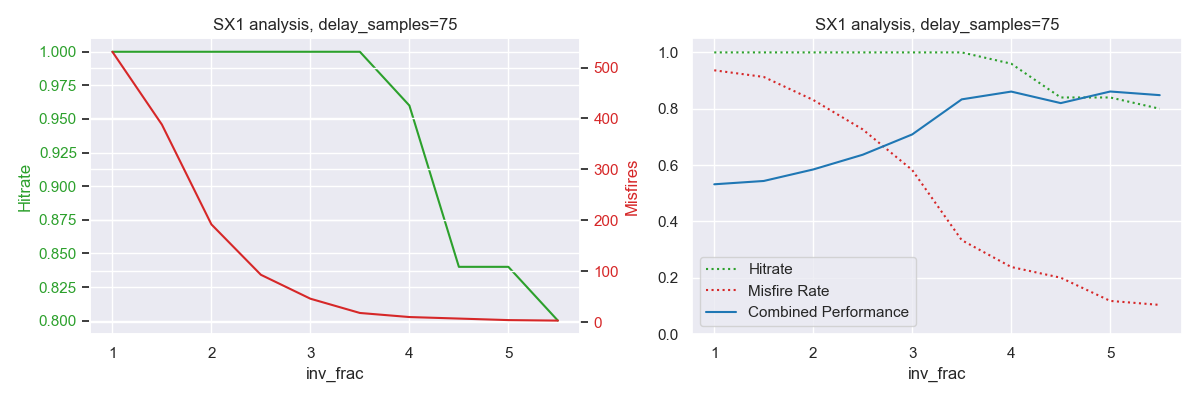

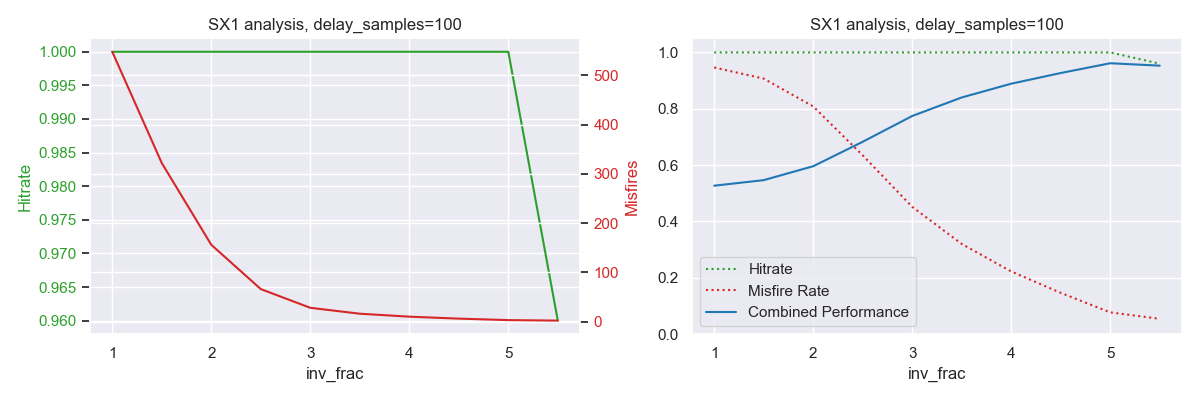

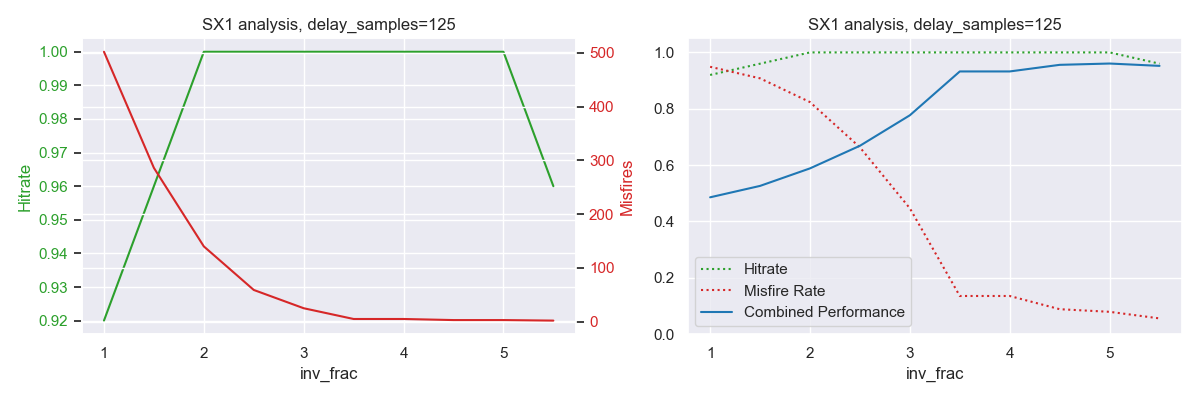

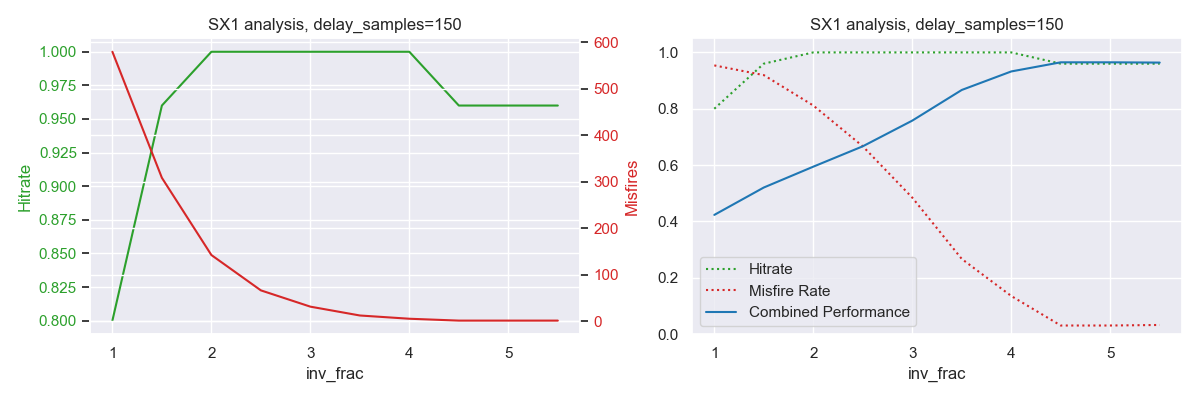

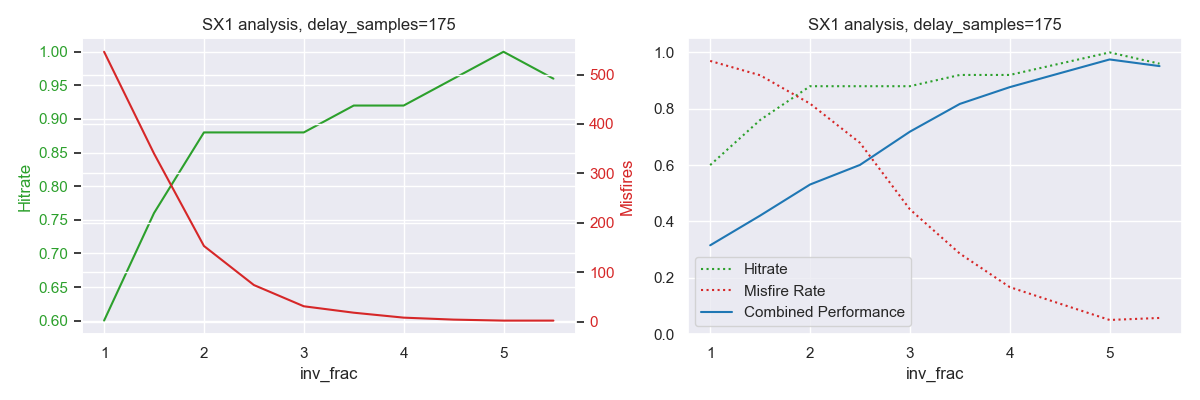

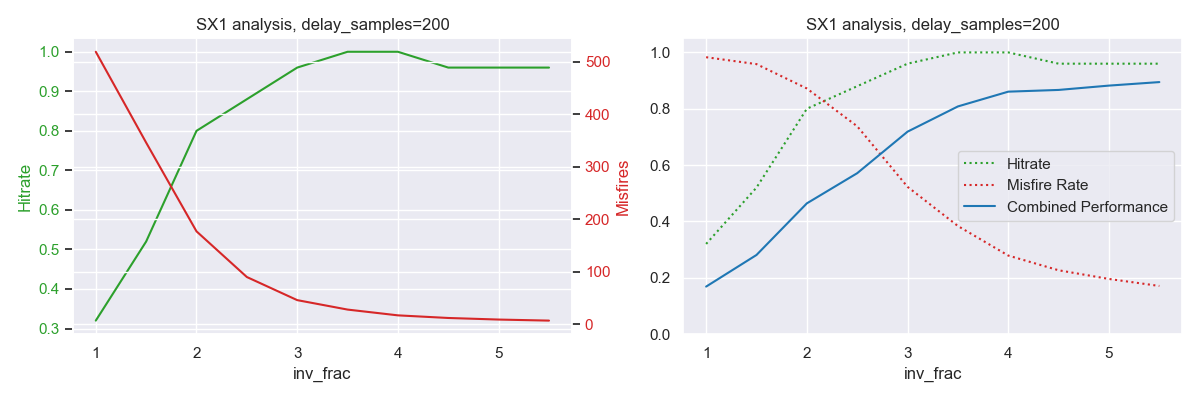

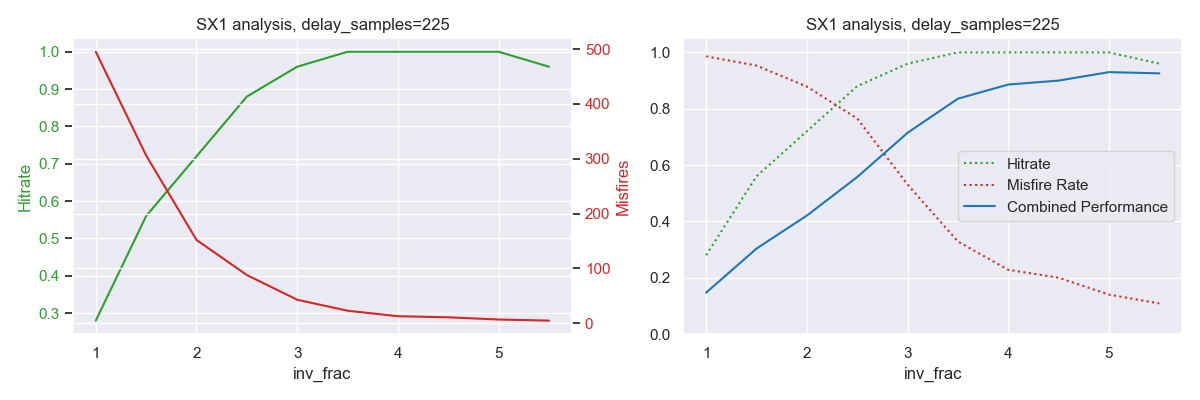

In [9]:
t1_pd_analyse = pd.read_csv("t1_performance_data")

for ds in delay_samples_vals:
    plot_inv_frac(t1_pd_analyse, delay_samples=ds)


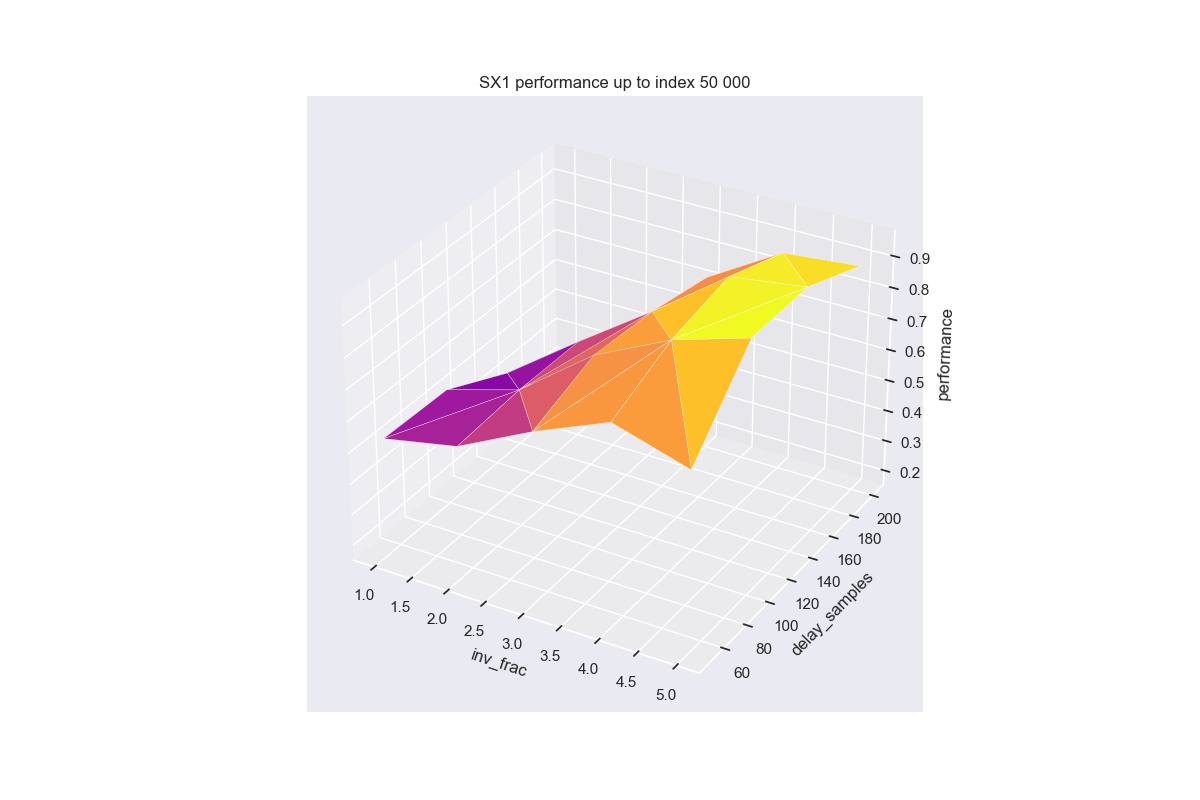

In [10]:
t1_pd_analyse = pd.read_csv("t1_performance_data")
plot_all_3d(t1_pd_analyse, title="SX1 performance up to index 50 000")


In [13]:
%%time

t2 = SignalData(data["SX1"], 
                truth_data = SX1_truth_data,
                zero_detector_alg=zero_detector2,
               )

inv_frac_vals = np.arange(2, 7 + 0.25, 0.25)  # Add step size to endpoint to include endpoint
delay_samples_vals = np.arange(50, 350 + 15, 15)  # Add step size to endpoint to include endpoint
t2_all_test_params = t2.get_performance(inv_frac_vals = inv_frac_vals,
                                        delay_samples_vals = delay_samples_vals,
                                        tolerance = 100e-6,
                                        verbose = True,
                                       )
t2_pd = pd.DataFrame(t2_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
t2_pd.to_csv("t2_performance_data")
t2_pd_analyse = pd.read_csv("t2_performance_data")


..................... 50
.....................
..................... 65
.....................
..................... 80
.....................
..................... 95
.....................
..................... 110
.....................
..................... 125
.....................
..................... 140
.....................
..................... 155
.....................
..................... 170
.....................
..................... 185
.....................
..................... 200
.....................
..................... 215
.....................
..................... 230
.....................
..................... 245
.....................
..................... 260
.....................
..................... 275
.....................
..................... 290
.....................
..................... 305
.....................
..................... 320
.....................
..................... 335
.....................
..................... 350
..................

In [4]:
plot_inv_frac(t2_pd_analyse, delay_samples=125)
plot_inv_frac(t2_pd_analyse, delay_samples=140)
plot_inv_frac(t2_pd_analyse, delay_samples=305)


NameError: name 'plot_inv_frac' is not defined

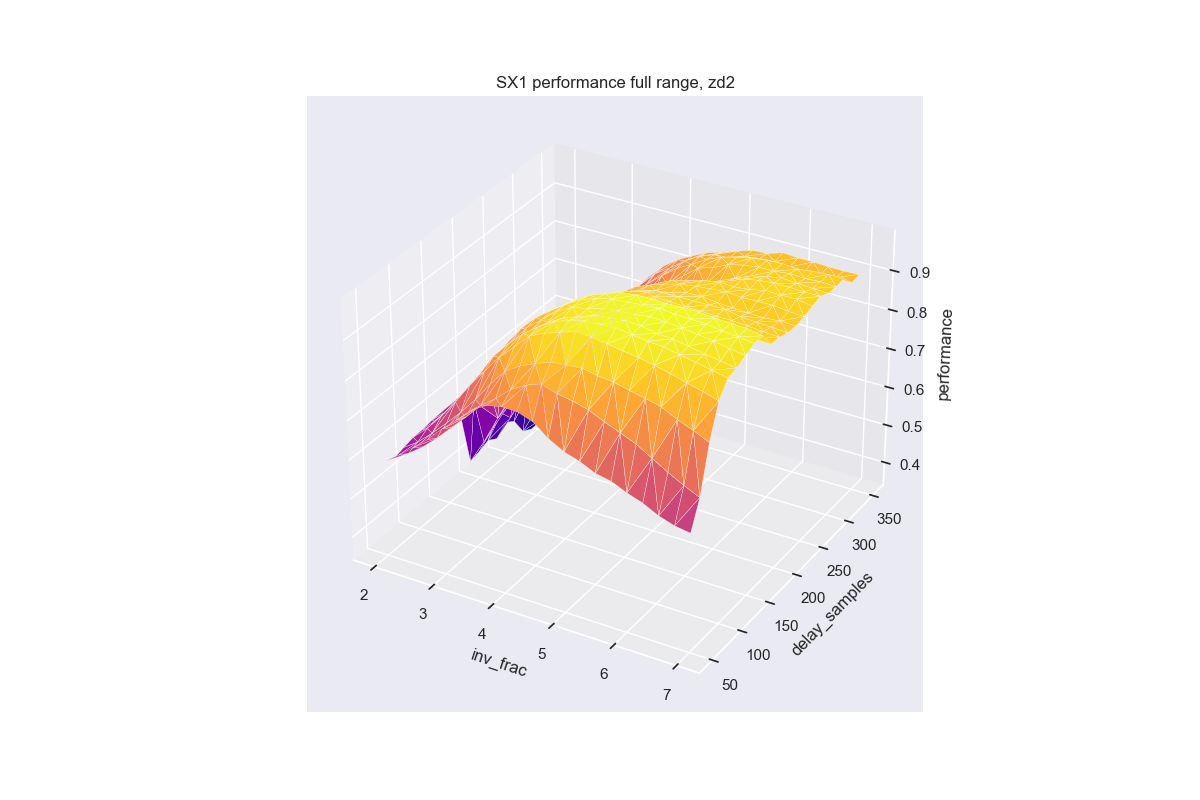

In [12]:
t2_pd_analyse = pd.read_csv("t2_performance_data 2023 08 21 - SX1 8hrs to compute")
plot_all_3d(t2_pd_analyse, title="SX1 performance full range, zd2")


In [15]:
# Make sig + noise, SX1+XN1, using SX1 truth data

SX1_t, SX1_sig = data["SX1"]
XN1_t, XN1_sig = data["XN1"]

print("len(SX1_t):", len(SX1_t))
print("len(XN1_t):", len(XN1_t))
trim = min(len(SX1_t), len(XN1_t))
SX1_sig = np.array(SX1_sig[:trim])
XN1_sig = np.array(XN1_sig[:trim])
print(f"Is time series (trimmed to [:{trim}]) of SX1 & XN1 the same?:", SX1_sig == XN1_sig)

combo_t = SX1_t[:trim]
combo_sig = SX1_sig + XN1_sig

data["SX1+XN1"] = [combo_t, combo_sig]


len(SX1_t): 1006484
len(XN1_t): 3010216
Is time series (trimmed to [:1006484]) of SX1 & XN1 the same?: [False False False ... False False False]


In [30]:
image2 = InteractiveTrigger(
        data["SX1+XN1"],
        slice_start=0,
        slice_end=3000,
        zero_detector_alg=zero_detector2,
    )

interact(image2.update,
      delay_samples=widgets.IntSlider(min=0, max=300, step=1, value=DELAY_SAMPLES), 
      inv_frac=widgets.FloatSlider(min=0, max=6, step=0.1, value=INV_FRAC)
    )


NameError: name 'InteractiveTrigger' is not defined

In [ ]:
%%time

t3 = SignalData(data["SX1+XN1"], 
                truth_data = SX1_truth_data,
                zero_detector_alg=zero_detector2,
               )

inv_frac_vals = np.arange(2, 7 + 0.25, 0.25)  # Add step size to endpoint to include endpoint
delay_samples_vals = np.arange(50, 350 + 15, 15)  # Add step size to endpoint to include endpoint
t3_all_test_params = t3.get_performance(inv_frac_vals = inv_frac_vals,
                                        delay_samples_vals = delay_samples_vals,
                                        tolerance = 100e-6,
                                        verbose = True,
                                       )
t3_pd = pd.DataFrame(t3_all_test_params)  # Faster to pass list of dicts than to add rows iteratively
t3_pd.to_csv("t3_performance_data")


In [ ]:
t3_pd_analyse = pd.read_csv("t3_performance_data")
plot_inv_frac(t3_pd_analyse)
plot_all_3d(t3_pd_analyse, title="SX1+XN1 performance full range, SX1 truth data, zd2")
